In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import empyrical as ep
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def brownian_correlation(prices1, volumes1, prices2, volumes2):
    # 计算价格序列的Pearson相关系数
    price_correlation, _ = pearsonr(prices1, prices2)
    # 计算成交量序列的Pearson相关系数
    volume_correlation, _ = pearsonr(volumes1, volumes2)
    # 计算Brownian相关系数
    brownian_corr = np.sqrt(price_correlation ** 2 + volume_correlation ** 2)

    return brownian_corr

In [3]:
# 遍历二维序列，选择每一个窗口序列，计算其与其他所有同长度序列的Brownian相关系数
# 选择典型序列
def gnerate_signal_for_pairs(pairs,typical_price, typical_volume, typical_signal):
    # 计算Brownian相关系数
    brownian_corr = []
    for price, volume, signal in pairs:
        brownian_corr.append(brownian_correlation(typical_price, typical_volume, price, volume))
    # 选择相关系数最高的7个窗口，不含典型序列自身
    # 相关系数最高的7个窗口
    top7 = np.argsort(brownian_corr)[-8:-1]
    # 计算相关系数最高的7个窗口的平均价格序列和平均成交量序列
    # 平均价格序列
    mean_price = np.mean([pairs[i][0] for i in top7], axis=0)
    # 平均成交量序列
    mean_volume = np.mean([pairs[i][1] for i in top7], axis=0)
    # 计算平均价格序列和平均成交量序列的涨跌幅
    # 平均价格序列的涨跌幅
    mean_price_changes = np.diff(mean_price)
    # 平均成交量序列的涨跌幅
    mean_volume_changes = np.diff(mean_volume)
    # 将得到的平均价格序列涨跌幅和平均成交量序列涨跌幅作为典型序列的预测价格涨跌幅和预测成交量涨跌幅
    # 根据所得预测价格涨跌幅和预测成交量涨跌幅，设定交易信号
    # 交易信号
    # 遍历预测价格涨跌幅和预测成交量涨跌幅
    for price_change, volume_change in zip(mean_price_changes, mean_volume_changes):
        # 如果预测价格涨跌幅和预测成交量涨跌幅均大于0，买入
        if price_change > 0 and volume_change > 0:
            typical_signal.append(1)
        # 如果预测价格涨跌幅和预测成交量涨跌幅均小于0，卖出
        elif price_change < 0 and volume_change < 0:
            typical_signal.append(-1)
        # 其他情况不操作
        else:
            typical_signal.append(0)
    typical_signal.append(0)
    return typical_signal

In [4]:
#成交量+收盘价
def generate_signal_for_df1(df):
    # 成交量取对数后标准化

    # 使用 StandardScaler 进行标准化
    scaler = StandardScaler()
    df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))

    # 使用 StandardScaler 进行标准化
    scaler = StandardScaler()
    df['std_Close'] = scaler.fit_transform(df['close'].values.reshape(-1, 1))
    # 轮动取时间窗口为30的二维序列（取两个series出来）
    # 价格序列
    prices = df['std_Close'].values
    # 成交量序列
    volumes = df['std_Vol'].values
    # 交易信号序列
    signals = []

    # 遍历两个序列，取时间窗口为30的二维序列
    # 时间窗口大小
    window = 30
    # 价格涨跌幅阈值
    price_change_threshold = 0.01
    # 成交量涨跌幅阈值
    volume_change_threshold = 0.01
    # 三维序列，添加signal列
    price_volume_pairs = []
    # 遍历序列
    for i in range(0, len(prices), window):
        # 取时间窗口为30的二维序列
        price_volume_pairs.append((prices[i:i + window], volumes[i:i + window], signals[i:i + window]))
    
    for index, item in enumerate(tqdm(price_volume_pairs)):
        typical_price, typical_volume, typical_signal = item
        price_volume_pairs[index] = (
        (typical_price, typical_volume, gnerate_signal_for_pairs(price_volume_pairs,typical_price, typical_volume, typical_signal)))
    
    df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
    return df['Signal']

In [5]:
#持仓量+收盘价
def generate_signal_for_df2(df):
    # 成交量取对数后标准化

    # 使用 StandardScaler 进行标准化
    scaler = StandardScaler()
    df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))

    # 使用 StandardScaler 进行标准化
    scaler = StandardScaler()
    df['std_Close'] = scaler.fit_transform(df['close'].values.reshape(-1, 1))
    # 轮动取时间窗口为30的二维序列（取两个series出来）
    # 价格序列
    prices = df['std_Close'].values
    # 持仓量序列
    ois = df['std_Oi'].values
    # 交易信号序列
    signals = []

    # 遍历两个序列，取时间窗口为30的二维序列
    # 时间窗口大小
    window = 30
    # 价格涨跌幅阈值
    price_change_threshold = 0.01
    # 持仓量涨跌幅阈值
    oi_change_threshold = 0.01
    # 三维序列，添加signal列
    price_oi_pairs = []
    # 遍历序列
    for i in range(0, len(prices), window):
        # 取时间窗口为30的二维序列
        price_oi_pairs.append((prices[i:i + window], ois[i:i + window], signals[i:i + window]))
    
    for index, item in enumerate(tqdm(price_oi_pairs)):
        typical_price, typical_oi, typical_signal = item
        price_oi_pairs[index] = (
    (typical_price, typical_oi, gnerate_signal_for_pairs(price_oi_pairs,typical_price, typical_oi, typical_signal)))
        
    df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
    return df['Signal']

In [6]:
st_sel_univ = ['AG', 'AL', 'NI', 'ZN', 'PB', 'CU', 'SN',
               'RB', 'HC', 'I', 'J', 'JM', 'FG', 'SA', 'SF', 'SM',
               'BU', 'L', 'MA', 'PP', 'RU', 'V', 'TA', 'FU', 'EG', 'SP',
               'A', 'M', 'P', 'OI', 'Y', 'SR', 'CF', 'C', 'RM']

In [7]:
#行情数据
sec_post_1d_df = pd.read_pickle(r'/Users/tiancaixiaohuoban/Desktop/实习/买方实习/中信建投期货（金融工程）/策略设计/dom_cont_post_1d')
sec_post_1d_df

date           2010-01-04  2010-01-05  2010-01-06  2010-01-07  2010-01-08  \
A  open          1.005669    1.002465    1.002218    1.026621    0.995810   
   high          1.008134    1.006162    1.033769    1.032290    0.998275   
   low           0.998028    1.000739    1.000000    0.979788    0.972886   
   close         1.000000    1.002218    1.023909    0.996796    0.981267   
   pct_change    0.000000    0.002218    0.021643   -0.026481   -0.015579   
...                   ...         ...         ...         ...         ...   
ZN close         1.000000    1.010030    1.014229    1.013529    0.989503   
   pct_change    0.000000    0.010030    0.004157   -0.000690   -0.023705   
   volume       37.920800   47.084800   41.559400   52.049800   61.431800   
   amount      407.794507  506.244472  452.561184  572.035483  653.285836   
   oi           15.971200   16.802000   16.154400   14.698600   14.068000   

date           2010-01-11  2010-01-12  2010-01-13  2010-01-14  2010-01-15  \
A  open          0.988908    0.985950    0.962534    0.971900    0.962534   
   high          0.998275    0.993098    0.970668    0.971900    0.973379   
   low           0.988908    0.981267    0.960316    0.965738    0.961794   
   close         0.993591    0.986936    0.963520    0.965985    0.964999   
   pct_change    0.012560   -0.006698   -0.023726    0.002558   -0.001021   
...                   ...         ...         ...         ...         ...   
ZN close         1.013996    1.002566    0.954047    0.961512    0.954980   
   pct_change    0.024752   -0.011272   -0.048395    0.007824   -0.006793   
   volume       37.344600   44.854800   36.039000   36.066600   41.209200   
   amount      403.436882  479.215884  371.271720  373.466084  423.367735   
   oi           13.573800   14.719000   13.454000   14.202400   13.316600   

date           ...  2024-01-12  2024-01-15  2024-01-16  2024-01-17  \
A  open        ...    1.119819    1.115857    1.117489    1.122616   
   high        ...    1.120052    1.117722    1.126811    1.128675   
   low         ...    1.111196    1.106535    1.112129    1.117023   
   close       ...    1.113061    1.115158    1.122616    1.118887   
   pct_change  ...   -0.006242    0.001884    0.006688   -0.003322   
...            ...         ...         ...         ...         ...   
ZN close       ...    1.149238    1.154132    1.151685    1.147605   
   pct_change  ...   -0.003771    0.004258   -0.002120   -0.003542   
   volume      ...    6.810800    9.279400    6.821800    8.139200   
   amount      ...   71.975769   97.981510   72.638088   86.283250   
   oi          ...    5.942900    5.315600    4.716700    8.297100   

date           2024-01-18  2024-01-19  2024-01-22  2024-01-23  2024-01-24  \
A  open          1.117722    1.114459    1.115158    1.111429    1.118654   
   high          1.119353    1.118188    1.115857    1.118887    1.124947   
   low           1.108633    1.110264    1.109565    1.107468    1.114692   
   close         1.112595    1.113993    1.111429    1.116557    1.121684   
   pct_change   -0.005624    0.001257   -0.002301    0.004613    0.004592   
...                   ...         ...         ...         ...         ...   
ZN close         1.129657    1.124490    1.125034    1.135912    1.155764   
   pct_change   -0.015640   -0.004574    0.000484    0.009669    0.017477   
   volume       13.373300    9.271600    8.455000    9.264500   12.441900   
   amount      139.483184   96.035770   87.723255   96.273565  131.348779   
   oi            8.969500    9.068100    8.966600    8.976100    8.534000   

date           2024-01-25  
A  open          1.121684  
   high          1.123315  
   low           1.112362  
   close         1.112595  
   pct_change   -0.008103  
...                   ...  
ZN close         1.162290  
   pct_change    0.005647  
   volume       10.244300  
   amount      109.345189  
   oi            8.951800  

[496 rows x 3419 columns]

In [8]:
# df = sec_post_1d_df.loc['AG'].T
# df = df.fillna(df.mean())

In [9]:
# #test
# test_signal_df1 = generate_signal_for_df1(df.head(3390))

In [10]:
# 循环产生信号（成交量+价格）
for asset in st_sel_univ:
    print(asset)
    df = sec_post_1d_df.loc[asset].T
    df = df.fillna(df.mean())
    if (asset=='AG'):
        test_signal_df1 = generate_signal_for_df1(df.head(3390))
        continue
    # 产生信号
    signal = generate_signal_for_df1(df.head(3390))
    test_signal_df1 = pd.concat([test_signal_df1, signal], axis=1)

<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Close'] = scaler.fit_transform(df['close'].values.reshape(-1, 1))
  0%|          | 0/113 [00:00<?, ?it/s]

AG


/Users/tiancaixiaohuoban/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 113/113 [00:02<00:00, 49.34it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

AL


100%|██████████| 113/113 [00:00<00:00, 173.82it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

NI


100%|██████████| 113/113 [00:00<00:00, 190.50it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

ZN


100%|██████████| 113/113 [00:00<00:00, 114.24it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

PB


100%|██████████| 113/113 [00:00<00:00, 250.26it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

CU


100%|██████████| 113/113 [00:01<00:00, 108.41it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

SN


100%|██████████| 113/113 [00:00<00:00, 229.01it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

RB


100%|██████████| 113/113 [00:01<00:00, 111.25it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

HC


100%|██████████| 113/113 [00:00<00:00, 240.15it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

I


100%|██████████| 113/113 [00:00<00:00, 175.18it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

J


100%|██████████| 113/113 [00:00<00:00, 147.17it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

JM


100%|██████████| 113/113 [00:00<00:00, 157.19it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

FG


100%|██████████| 113/113 [00:00<00:00, 141.22it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

SA


100%|██████████| 113/113 [00:00<00:00, 469.28it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

SF


100%|██████████| 113/113 [00:00<00:00, 276.72it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

SM


100%|██████████| 113/113 [00:00<00:00, 272.68it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

BU


100%|██████████| 113/113 [00:00<00:00, 204.35it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

L


100%|██████████| 113/113 [00:01<00:00, 104.41it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

MA


100%|██████████| 113/113 [00:00<00:00, 211.11it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

PP


100%|██████████| 113/113 [00:00<00:00, 153.16it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

RU


100%|██████████| 113/113 [00:01<00:00, 112.77it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

V


100%|██████████| 113/113 [00:00<00:00, 235.85it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

TA


100%|██████████| 113/113 [00:01<00:00, 104.64it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

FU


100%|██████████| 113/113 [00:00<00:00, 349.42it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

EG


100%|██████████| 113/113 [00:00<00:00, 392.24it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

SP


100%|██████████| 113/113 [00:00<00:00, 364.08it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

A


100%|██████████| 113/113 [00:01<00:00, 103.26it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

M


100%|██████████| 113/113 [00:01<00:00, 99.49it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

P


100%|██████████| 113/113 [00:01<00:00, 102.88it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

OI


100%|██████████| 113/113 [00:00<00:00, 150.85it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

Y


100%|██████████| 113/113 [00:01<00:00, 103.47it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

SR


100%|██████████| 113/113 [00:01<00:00, 100.71it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

CF


100%|██████████| 113/113 [00:00<00:00, 170.33it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

C


100%|██████████| 113/113 [00:00<00:00, 187.12it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])
<ipython-input-4-c3b15e353e63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Vol'] = scaler.fit_transform(df['volume'].values.reshape(-1, 1))
<ipython-input-4-c3b15e353e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

RM


100%|██████████| 113/113 [00:00<00:00, 146.30it/s]
<ipython-input-4-c3b15e353e63>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_volume_pairs])


In [11]:
# 循环产生信号（持仓量+价格）
for asset in st_sel_univ:
    print(asset)
    df = sec_post_1d_df.loc[asset].T
    df = df.fillna(df.mean())
    if (asset=='AG'):
        test_signal_df2 = generate_signal_for_df2(df.head(3390))
        continue
    # 产生信号
    signal = generate_signal_for_df2(df.head(3390))
    test_signal_df2 = pd.concat([test_signal_df2, signal], axis=1)

<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Close'] = scaler.fit_transform(df['close'].values.reshape(-1, 1))
  0%|          | 0/113 [00:00<?, ?it/s]/Users/tiancaixiaohuoban/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation co

AG


100%|██████████| 113/113 [00:00<00:00, 129.42it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

AL


100%|██████████| 113/113 [00:00<00:00, 162.80it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

NI


100%|██████████| 113/113 [00:00<00:00, 170.64it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

ZN


100%|██████████| 113/113 [00:01<00:00, 100.97it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

PB


100%|██████████| 113/113 [00:00<00:00, 279.80it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

CU


100%|██████████| 113/113 [00:01<00:00, 103.73it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

SN


100%|██████████| 113/113 [00:00<00:00, 231.80it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

RB


100%|██████████| 113/113 [00:01<00:00, 89.90it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

HC


100%|██████████| 113/113 [00:00<00:00, 190.33it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

I


100%|██████████| 113/113 [00:00<00:00, 158.28it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

J


100%|██████████| 113/113 [00:00<00:00, 121.24it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

JM


100%|██████████| 113/113 [00:00<00:00, 139.75it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

FG


100%|██████████| 113/113 [00:00<00:00, 138.49it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

SA


100%|██████████| 113/113 [00:00<00:00, 434.87it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

SF


100%|██████████| 113/113 [00:00<00:00, 307.40it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

SM


100%|██████████| 113/113 [00:00<00:00, 281.48it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

BU


100%|██████████| 113/113 [00:00<00:00, 220.06it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

L


100%|██████████| 113/113 [00:01<00:00, 110.75it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

MA


100%|██████████| 113/113 [00:00<00:00, 197.43it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

PP


100%|██████████| 113/113 [00:00<00:00, 197.25it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

RU


100%|██████████| 113/113 [00:01<00:00, 109.82it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

V


100%|██████████| 113/113 [00:00<00:00, 170.35it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

TA


100%|██████████| 113/113 [00:01<00:00, 77.57it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

FU


100%|██████████| 113/113 [00:00<00:00, 295.09it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

EG


100%|██████████| 113/113 [00:00<00:00, 233.54it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

SP


100%|██████████| 113/113 [00:00<00:00, 326.94it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

A


100%|██████████| 113/113 [00:01<00:00, 81.94it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

M


100%|██████████| 113/113 [00:01<00:00, 89.61it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

P


100%|██████████| 113/113 [00:01<00:00, 93.67it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

OI


100%|██████████| 113/113 [00:00<00:00, 143.15it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

Y


100%|██████████| 113/113 [00:01<00:00, 95.05it/s] 
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

SR


100%|██████████| 113/113 [00:01<00:00, 93.34it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

CF


100%|██████████| 113/113 [00:00<00:00, 171.84it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

C


100%|██████████| 113/113 [00:00<00:00, 178.99it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])
<ipython-input-5-73a796cc1bad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['std_Oi'] = scaler.fit_transform(df['oi'].values.reshape(-1, 1))
<ipython-input-5-73a796cc1bad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

RM


100%|██████████| 113/113 [00:00<00:00, 159.17it/s]
<ipython-input-5-73a796cc1bad>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'] = np.concatenate([item[2] for item in price_oi_pairs])


In [12]:
test_signal_df1 = test_signal_df1.fillna(0)
test_signal_df2 = test_signal_df2.fillna(0)

In [13]:
test_signal_df1.columns = st_sel_univ
test_signal_df2.columns = st_sel_univ

In [14]:
test_signal_df1 = test_signal_df1.T
test_signal_df2 = test_signal_df2.T

In [15]:
test_sig_df1 = test_signal_df1
test_sig_df2 = test_signal_df2

In [16]:
#收益率序列
pct_df1 = sec_post_1d_df.xs('close',level=1).pct_change(axis=1).reindex(test_sig_df1.index)
pct_df2 = sec_post_1d_df.xs('close',level=1).pct_change(axis=1).reindex(test_sig_df2.index)

In [17]:
#手续费
fee_df1 = abs(test_sig_df1.diff(axis=1).fillna(0))*1e-4 #单边万一的手续费
fee_df2 = abs(test_sig_df2.diff(axis=1).fillna(0))*1e-4 #单边万一的手续费

In [18]:
#当天的信号作用到第二天，用close计算出来的收益率，shift-1.  
pnl_seires1 = ((pct_df1.shift(-1,axis=1).fillna(0)*test_sig_df1-fee_df1).mean()+1).cumprod()
pnl_seires2 = ((pct_df2.shift(-1,axis=1).fillna(0)*test_sig_df2-fee_df2).mean()+1).cumprod()

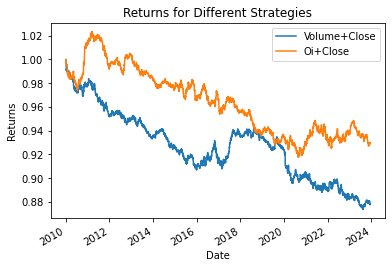

In [19]:
# 创建一个绘图对象
ax = pnl_seires1.plot(label='Volume+Close')

# 绘制第二个Series
pnl_seires2.plot(ax=ax, label='Oi+Close')

# 添加标题和标签
plt.title('Returns for Different Strategies')
plt.xlabel('Date')
plt.ylabel('Returns')

# 添加图例
plt.legend()

# 显示图形
plt.show()

In [20]:
return_df1 = (pct_df1.shift(-1,axis=1).fillna(0)*test_sig_df1-fee_df1).mean()
#通过Empyrical 计算夏普等绩效指标。无风险利率取0% 
total_return = ep.cum_returns_final(return_df1)
annualized_return = ep.annual_return(return_df1)
max_drawdown = ep.max_drawdown(return_df1)
sharpe_ratio = ep.sharpe_ratio(return_df1)
# Print performance metrics
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Total Return: -12.20%
Annualized Return: -0.95%
Max Drawdown: -12.65%
Sharpe Ratio: -0.6548


In [21]:
return_df2= (pct_df2.shift(-1,axis=1).fillna(0)*test_sig_df2-fee_df2).mean()
#通过Empyrical 计算夏普等绩效指标。无风险利率取0% 
total_return = ep.cum_returns_final(return_df2)
annualized_return = ep.annual_return(return_df2)
max_drawdown = ep.max_drawdown(return_df2)
sharpe_ratio = ep.sharpe_ratio(return_df2)
# Print performance metrics
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Total Return: -7.05%
Annualized Return: -0.54%
Max Drawdown: -10.35%
Sharpe Ratio: -0.3771
